In [1]:
# lib

import os
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
# from PIL import Image
from scipy import ndimage

import math
from lr_utils import load_dataset
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
# _helper functions_

def sigmoid(x):
    '''
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    '''
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    '''
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    '''
    s = np.maximum(0,x)
    
    return s

def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return (train_X, train_Y, test_X, test_Y)

def load_cat_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) #  train set features
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) #  train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:]) #  test set features
    test_set_y_orig = np.array(test_dataset['test_set_y'][:]) #  test set labels

    classes = np.array(test_dataset['list_classes'][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict(X, y, parameters):
    '''
    This function is used to predict the results of a  n-layer neural network.    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model    
    Returns:
    p -- predictions for the given dataset X
    '''
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print('Accuracy: '  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

   
def predict_dec(parameters, X):
    '''
    Used for plotting decision boundary.    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)    
    Returns:
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    '''        
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [3]:
# modules

def forward_propagation(X, parameters):
    '''
    Implements the forward propagation (and computes the loss)    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true 'label' vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing  parameters 'W1', 'b1', 'W2', 'b2', 'W3', 'b3':
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    '''        
    # retrieve parameters
    W1 = parameters['W1'];			b1 = parameters['b1']
    W2 = parameters['W2'];			b2 = parameters['b2']
    W3 = parameters['W3'];			b3 = parameters['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = ( W1 @ X  ) + b1	;			a1 = relu(z1)
    z2 = ( W2 @ a1 ) + b2	;			a2 = relu(z2)
    z3 = ( W3 @ a2 ) + b3	;			a3 = sigmoid(z3)
    
    cache = (	z1, a1, W1, b1,
z2, a2, W2, b2,
z3, a3, W3, b3	)
    
    return (a3, cache)

def backward_propagation(X, Y, cache):
    '''
    Implement the backward propagation
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true 'label' vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    '''
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = dz3 @ a2.T
    db3 = np.sum(dz3, axis= 1, keepdims= True)
    
    da2 = W3.T @ dz3
    dz2 = da2 * np.int64(a2 > 0)
    dW2 = dz2 @ a1.T
    db2 = np.sum(dz2, axis= 1, keepdims= True)
    
    da1 = W2.T @ dz2
    dz1 = da1 * np.int64(a1 > 0)
    dW1 = dz1 @ X.T
    db1 = np.sum(dz1, axis= 1, keepdims= True)
    
    gradients = {             'dz3': dz3, 'dW3': dW3, 'db3': db3,
                  'da2': da2, 'dz2': dz2, 'dW2': dW2, 'db2': db2,
                  'da1': da1, 'dz1': dz1, 'dW1': dW1, 'db1': db1  }
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    '''
    Update parameters using gradient descent    
    Arguments:
    parameters -- python dictionary containing parameters 
    grads -- python dictionary containing gradients, output of n_model_backward    
    Returns:
    parameters -- python dictionary containing updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    '''
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters['W' + str(k+1)] = parameters['W' + str(k+1)] - learning_rate * grads['dW' + str(k+1)]
        parameters['b' + str(k+1)] = parameters['b' + str(k+1)] - learning_rate * grads['db' + str(k+1)]
        
    return parameters

def compute_loss(a3, Y):    
    '''
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- 'true' labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    '''    
    m = Y.shape[1]
    logprobs = ( -np.log(a3) * Y )  +  ( -np.log(1 - a3) * (1 - Y) )
    loss = 1./m * np.nansum(logprobs)
    
    return loss

In [4]:
# integrating modules to structure the Neural Network

def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    '''
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    '''
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]  # hard coded for our specific purpose
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss
        cost = compute_loss(a3, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [5]:
# matlplot window setting
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

"He Initialization" is based on He et al., 2015. The initialization will use:<br> `sqrt(2./layers_dims[l-1])` as a multiplicative factor. This will not only break the symmtery but makes the learning much faster.

In [7]:
def initialize_parameters_he(layer_dim):
    '''
    Arguments:
    layer_dim -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)    
    '''
    np.random.seed(3)
    parameters = {}
    L = len(layer_dim) - 1
    
    for l in range(1,L+1):
        parameters[ 'W'+str(l) ] =  np.sqrt(2./layer_dim[l-1]) * np.random.randn( layer_dim[l],layer_dim[l-1] )
        parameters[ 'b'+str(l) ] = np.zeros( (layer_dim[l],1) )
        
    return(parameters)

### running the model adopting parameters He initialization



---------------------------------- Data visualization ------------------------------------



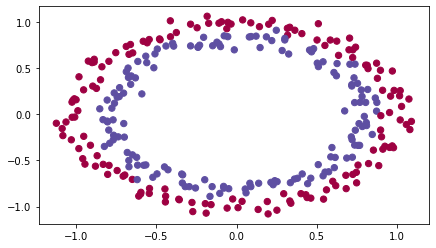



---------------------------------- Model Testing - Cost: ------------------------------------

Cost after iteration 0: 0.8830537463419761
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893807
Cost after iteration 4000: 0.6082958970572937
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.4138645817071793
Cost after iteration 7000: 0.3117803464844441
Cost after iteration 8000: 0.23696215330322556
Cost after iteration 9000: 0.18597287209206828
Cost after iteration 10000: 0.15015556280371808
Cost after iteration 11000: 0.12325079292273548
Cost after iteration 12000: 0.09917746546525937
Cost after iteration 13000: 0.08457055954024274
Cost after iteration 14000: 0.07357895962677366


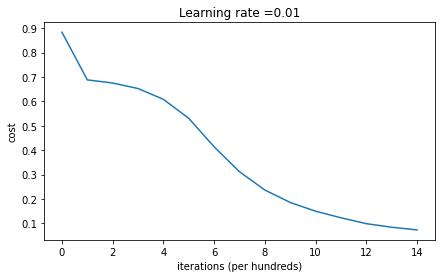

------------------------------ Accuracy ------------------------------------------
On the train set:
Accuracy: 0.9933333333333333
On the test set:
Accuracy: 0.96
---------------------------- Decision Boundary for Model with He Random initialization --------------------------------


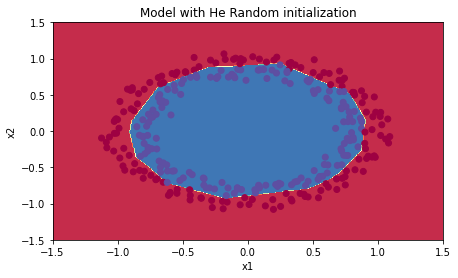

In [8]:
# data
print('\n\n---------------------------------- Data visualization ------------------------------------\n')
X_train, Y_train, X_test, Y_test = load_dataset()
plt.show()

# training the model adopting zero initialization 
print('\n\n---------------------------------- Model Testing - Cost: ------------------------------------\n')
parameters = model( X= X_train, Y= Y_train,
                    learning_rate= 0.01, num_iterations= 15000,
                    print_cost= True,
                    initialization='he' )
print('------------------------------ Accuracy ------------------------------------------')

print ("On the train set:"); 
yhat_train = predict(X_train, Y_train, parameters)
print ("On the test set:")
yhat_test = predict( X_test, Y_test, parameters )

print('---------------------------- Decision Boundary for Model with He Random initialization --------------------------------')

plt.title("Model with He Random initialization")
axes = plt.gca()
axes.set_xlim( -1.5,1.5 );  axes.set_ylim( -1.5,1.5 )
plot_decision_boundary( 
                            lambda x: predict_dec(parameters, x.T),
                            X= X_train, y= Y_train   )

The model learns well when He random initialization is adopted. 